In [ ]:
install.packages("tensorflow")
install.packages("keras")
install.packages("ISLR2")
install.packages("glmnet")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘here’, ‘png’, ‘config’, ‘reticulate’, ‘tfruns’, ‘tfautograph’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zeallot’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’




# Red neuronal de una capa (Hitters)

Configuramos los datos `Hitters` y separamos un conjunto de entrenamiento y de prueba:

In [ ]:
library(ISLR2)
Gitters <- na.omit(Hitters)
n <- nrow(Gitters)
set.seed(13)
ntest <- trunc(n / 3)
testid <- sample(1:n, ntest)

Ajustamos un modelo lineal.

In [ ]:
lfit <- lm(Salary ~ ., data = Gitters[-testid, ])
lpred <- predict(lfit, Gitters[testid, ])
with(Gitters[testid, ], mean(abs(lpred - Salary)))

[1] 254.6687

El paquete `glmnet` no usa fórmulas, preparamos a mano $x$ e $y$.

In [ ]:
x <- scale(model.matrix(Salary ~ . - 1, data = Gitters))
y <- Gitters$Salary

Ajustamos una modelo ridge:

In [ ]:
library (glmnet)
cvfit <- cv.glmnet(x[-testid, ], y[-testid], type.measure = "mae")
cpred <- predict(cvfit , x[testid, ], s = "lambda.min")
mean(abs(y[testid] - cpred))

Loading required package: Matrix

Loaded glmnet 4.1-3



[1] 252.2994

Definimos la estructura de la red

In [ ]:
library(keras)
modnn <- keras_model_sequential() %>%
         layer_dense(units = 50, 
                     activation = "relu",
                     input_shape = ncol(x)) %>%
         layer_dropout(rate = 0.4) %>%  
         layer_dense(units = 1)

Añadimos detalles a `modnn` que controlan el algoritmo de ajuste. 

Minimizamos pérdida de error cuadrado. El algoritmo mira el error medio absoluto en los datos de entrenamiento, y en los datos de validación si son provistos.

In [ ]:
modnn %>% compile(loss = "mse",
                  optimizer = optimizer_rmsprop(),
                  metrics = list("mean_absolute_error")
)

* Una *época* equivale al número de pasos de *SGD* necesarios para procesar $n$ observaciones. Dado que el conjunto de entrenamiento tiene $n = 176$, una época es de $176/32 = 5.5$ pasos.
* La función `fit()` tiene como argumento los datos de validación; estos datos no se utilizan en el ajuste, pero pueden usarse para seguir el progreso del modelo (en este caso informando del error medio absoluto). 
* Para ver más opciones de ajuste, hay que mirar `?fit.keras.engine.training.Model`.
* Si se ejecuta el comando `fit()` por segunda vez en la misma sesión de `R`, el proceso de ajuste continuará donde lo dejó.




In [ ]:
history <- modnn %>% fit(
  x[-testid, ], y[-testid], epochs = 1500, batch_size = 32,
  validation_data = list(x[testid, ], y[testid])
)

Podemos graficar el historial para mostrar el error medio absoluto de los datos de entrenamiento y de test.

`geom_smooth()` using formula 'y ~ x'



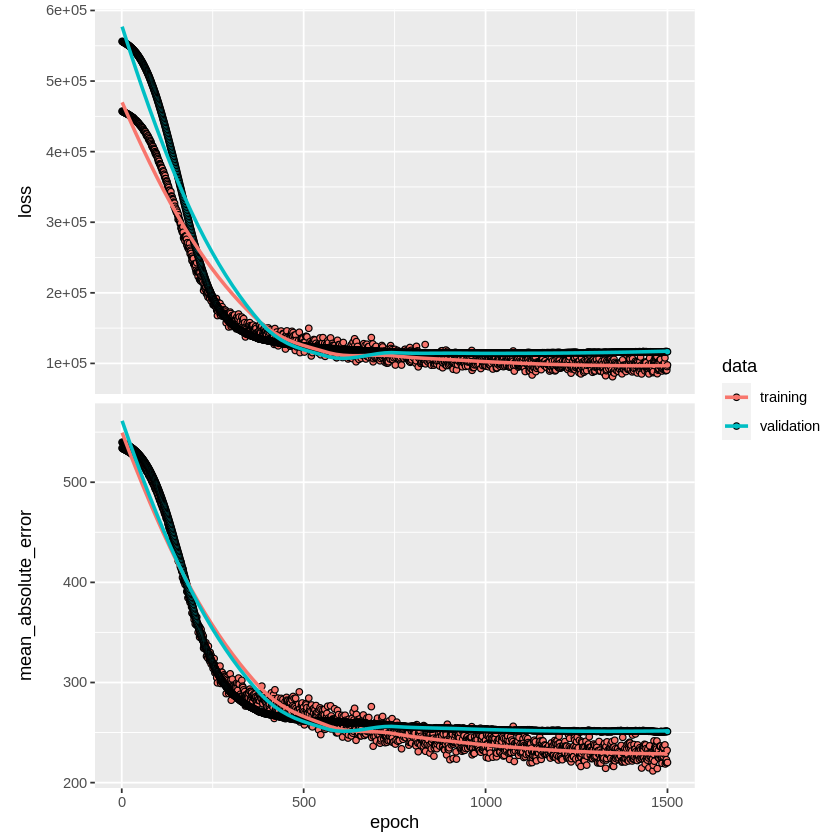

In [ ]:
plot(history)

Por último, predecimos a partir del modelo final, y evaluamos su rendimiento
en los datos de prueba. 

Debido al uso de SGD, los resultados varían ligeramente con cada
ajuste. 

Lamentablemente, la función `set.seed()` no garantiza resultados idénticos (ya que el ajuste se realiza en Python), por lo que los resultados serán ligeramente diferentes.

In [ ]:
npred <- predict(modnn, x[testid, ])
mean(abs(y[testid] - npred))

[1] 251.0529

# Red neuronal multicapa (MNIST)

El paquete `keras` viene con un número de conjuntos de datos de ejemplo, 
incluyendo los datos de dígitos de MNIST. 

Nuestro primer paso es cargar los datos MNIST con la función `dataset_mnist()`.

In [ ]:
library(keras)
mnist <- dataset_mnist()
x_train <- mnist$train$x
g_train <- mnist$train$y
x_test <- mnist$test$x
g_test <- mnist$test$y
dim(x_train)
dim(x_test)

[1] 60000    28    28

[1] 10000    28    28

Hay $60.000$ imágenes en los datos de entrenamiento y $10.000$ en los datos de prueba.

Las imágenes son de $28×28$, y se almacenan como una matriz tridimensional, por lo que necesitamos
que darles forma de matriz. 

Además, tenemos que codificar la etiqueta de la clase de una sola vez.
etiqueta. 

Por suerte, Keras tiene un montón de funciones incorporadas que hacen esto por nosotros.

In [ ]:
x_train <- array_reshape(x_train, c(nrow(x_train), 784))
x_test <- array_reshape(x_test, c(nrow(x_test), 784))
y_train <- to_categorical(g_train, 10)
y_test <- to_categorical(g_test, 10)

Las redes neuronales son sensibles a la escala de las entradas. Por ejemplo, la regularización de *ridge* y de *lasso* se ve afectada por la escala. En este caso, las entradas son valores de escala de grises de ocho bits entre $0$ y $255$, por lo que reescalamos al intervalo de la unidad.


In [ ]:
x_train <- x_train / 255
x_test <- x_test / 255

Ajustamos la red neuronal:

In [ ]:
modelnn <- keras_model_sequential()

modelnn %>% layer_dense(units = 256, 
                        activation = "relu",
                        input_shape = c(784)) %>%
            layer_dropout(rate = 0.4) %>%
            layer_dense(units = 128, activation = "relu") %>%
            layer_dropout(rate = 0.3) %>%
            layer_dense(units = 10, activation = "softmax")

*Summary* del modelo:


In [ ]:
summary(modelnn)

Model: "sequential_2"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 dense_6 (Dense)                    (None, 256)                     200960      
                                                                                
 dropout_3 (Dropout)                (None, 256)                     0           
                                                                                
 dense_5 (Dense)                    (None, 128)                     32896       
                                                                                
 dropout_2 (Dropout)                (None, 128)                     0           
                                                                                
 dense_4 (Dense)                    (None, 10)                      1290        
                                                                                
Total 

Los parámetros de cada capa incluyen un término de sesgo, lo que da lugar a un
número de parámetros de $235146$. 

Por ejemplo, la primera capa oculta implica $(784 + 1) × 256 = 200.960$ parámetros.

Minimizamos la *cross-entropy*:

In [ ]:
modelnn %>% compile(loss = "categorical_crossentropy",
                    optimizer = optimizer_rmsprop(),
                    metrics = c("accuracy"))

Entrenamos el modelo:

   user  system elapsed 
146.839  10.264 142.755 

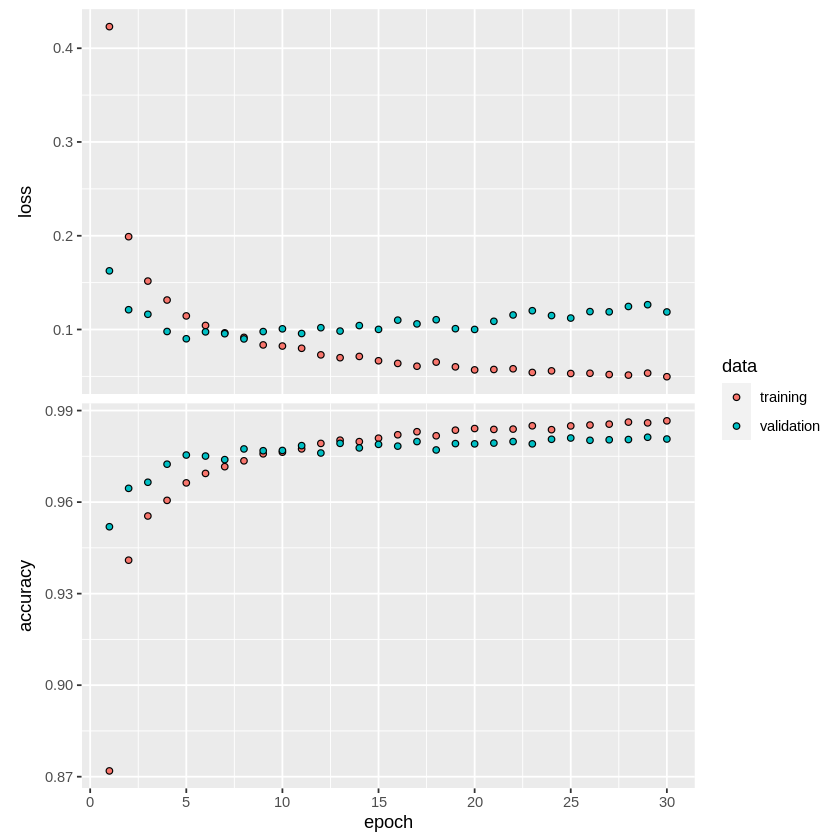

In [ ]:
system.time(
  history <- modelnn %>% fit(x_train, y_train, 
                             epochs = 30, 
                             batch_size = 128,
                             validation_split = 0.2)
)
plot(history, smooth = FALSE)

* El entrenamiento se realiza con el $80%$ de las $60000$ observaciones.
* El SGD utiliza lotes de $128$ observaciones para calcular el gradiente. Una época corresponde a 375 pasos.

Evaluamos nuestras predicciones:

In [ ]:
accuracy <- function(pred, truth)
mean(drop(pred) == drop(truth))

modelnn %>% predict_classes(x_test) %>% accuracy(g_test)

Para ajustar una regresión logística basta con omitir la capa oculta.

(`glmnet` es más lento para un dataset grande)

In [ ]:
modellr <- keras_model_sequential() % >%
  layer_dense(input _ shape = 784, units = 10,
  activation = "softmax")
summary(modellr)

Ajustamos el modelo.

In [ ]:
modellr %>% compile(loss = "categorical_crossentropy",
                    optimizer = optimizer_rmsprop(), 
                    metrics = c("accuracy"))
modellr %>% fit(x_train, y_train, 
                epochs = 30,
                batch_size = 128, 
                validation_split = 0.2)
modellr %>% predict_classes(x_test) 
        %>% accuracy(g_test)

# Ejercicio

Ajustar una red neuronal a los datos `Default`: 
* Utilice una sola capa oculta
con $10$ unidades, y regularización de *dropout*. 
* Compare el rendimiento de clasificación de su modelo con una regresión logística.